# Data Loading

In [1]:
import pandas as pd 
train_df = pd.read_json("./Data/train.json")
test_df = pd.read_json("./Data/test.json")
val_df = pd.read_json("./Data/dev.json")

# Implementation

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import networkx as nx
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm
import os
import pickle
import gc

# For BM25 baseline – install via: pip install rank_bm25
try:
    from rank_bm25 import BM25Okapi
except ImportError:
    print("Please install 'rank_bm25' package for BM25 baseline.")

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Updated import
from torch_geometric.utils import from_networkx, add_self_loops
from torch_geometric.nn import SAGEConv, GATConv, GCNConv

###########################
# GPU Memory & Determinism Config
###########################
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:256'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
main_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preprocess_device = main_device
print(f"Main device: {main_device}")
print(f"Preprocessing device: {preprocess_device}")

###########################
# Data Loading
###########################
print("Loading data...")
train_df = pd.read_json("./Data/train.json")
dev_df = pd.read_json("./Data/dev.json")
print(f"Train samples: {len(train_df)}, Dev samples: {len(dev_df)}")

###########################
# Edge Schema & Helper Functions
###########################
EDGE_SCHEMA = {
    'weight': 0.0,
    'type': 'unknown',
    'type_id': 0,
    'distance': 0,
    'semantic_sim': 0.0,
    'keyword_sim': 0.0,
    'query_sim': 0.0
}

def add_edge_with_schema(G, u, v, edge_type, **kwargs):
    attrs = EDGE_SCHEMA.copy()
    attrs['type'] = edge_type
    if edge_type == 'sequential':
        attrs['type_id'] = 0
    elif edge_type == 'keyword':
        attrs['type_id'] = 1
    elif edge_type == 'semantic':
        attrs['type_id'] = 2
    elif edge_type == 'query':
        attrs['type_id'] = 3
    attrs.update(kwargs)
    G.add_edge(u, v, **attrs)
    return G

###########################
# Graph & Embedding Construction
###########################
def build_optimized_graph(context, query=None, semantic_threshold=0.6, device=None):
    if device is None:
        device = preprocess_device
    model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
    G = nx.Graph()
    titles = [title for title, _ in context]
    texts = [" ".join(text) if isinstance(text, list) else text for _, text in context]
    
    for title in titles:
        G.add_node(title)
    
    # Batch-encode passages and force embeddings to CPU
    with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
        with torch.no_grad():
            batch_size = 32
            all_embeddings = []
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                batch_embs = model.encode(batch_texts, convert_to_tensor=True, device=device)
                # Ensure batch_embs is 2D and move to CPU
                batch_embs = batch_embs.cpu()
                all_embeddings.append(batch_embs)
            embeddings = torch.cat(all_embeddings, dim=0).cpu()
            if query is not None:
                query_emb = model.encode(query, convert_to_tensor=True, device=device).cpu()
    
    # Sequential edges
    for i in range(len(titles)):
        for j in range(i+1, min(i+4, len(titles))):
            distance = j - i
            weight = np.exp(-distance * 0.5)
            add_edge_with_schema(G, titles[i], titles[j], edge_type='sequential', weight=weight, distance=distance)
    
    # Keyword edges using TF-IDF
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
        X = tfidf.fit_transform(texts)
        from sklearn.metrics.pairwise import cosine_similarity
        tfidf_sim = cosine_similarity(X)
        flat_tfidf = tfidf_sim.flatten()
        tfidf_threshold = max(0.15, np.percentile(flat_tfidf, 75))
        for i in range(len(titles)):
            for j in range(i+1, len(titles)):
                if tfidf_sim[i, j] > tfidf_threshold:
                    if not G.has_edge(titles[i], titles[j]):
                        add_edge_with_schema(G, titles[i], titles[j], edge_type='keyword', weight=tfidf_sim[i, j], keyword_sim=tfidf_sim[i, j])
                    else:
                        G[titles[i]][titles[j]]['keyword_sim'] = tfidf_sim[i, j]
                        G[titles[i]][titles[j]]['weight'] = max(G[titles[i]][titles[j]]['weight'], tfidf_sim[i, j])
    except Exception as e:
        print(f"TF-IDF edge creation failed: {e}")
    
    # Semantic similarity edges using cosine similarity
    sim_matrix = torch.zeros((len(titles), len(titles)))
    for i in range(len(titles)):
        for j in range(i+1, len(titles)):
            sim = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
    if query is not None:
        query_sims = torch.zeros(len(titles))
        for i in range(len(titles)):
            query_sims[i] = util.pytorch_cos_sim(query_emb, embeddings[i]).item()
        if query_sims.max() > query_sims.min():
            query_sims = (query_sims - query_sims.min()) / (query_sims.max() - query_sims.min())
    
    flat_sims = sim_matrix.flatten()[sim_matrix.flatten() > 0]
    if len(flat_sims) > 0:
        adapt_threshold = max(semantic_threshold, flat_sims.mean() + 0.5 * flat_sims.std())
    else:
        adapt_threshold = semantic_threshold
        
    for i in range(len(titles)):
        for j in range(i+1, len(titles)):
            base_sim = sim_matrix[i, j].item()
            if query is not None:
                relevance_boost = query_sims[i] * query_sims[j] * 0.2
                adjusted_sim = base_sim + relevance_boost
            else:
                adjusted_sim = base_sim
            if adjusted_sim > adapt_threshold:
                if not G.has_edge(titles[i], titles[j]):
                    add_edge_with_schema(G, titles[i], titles[j], edge_type='semantic', weight=adjusted_sim, semantic_sim=base_sim)
                else:
                    G[titles[i]][titles[j]]['semantic_sim'] = base_sim
                    G[titles[i]][titles[j]]['weight'] = max(G[titles[i]][titles[j]]['weight'], adjusted_sim)
                    
    # Query edges
    if query is not None:
        query_node = "__QUERY__"
        G.add_node(query_node)
        for i, title in enumerate(titles):
            sim = query_sims[i].item()
            if sim > 0.4:
                add_edge_with_schema(G, query_node, title, edge_type='query', weight=sim, query_sim=sim)
    
    edge_counts = {etype: 0 for etype in ["sequential", "keyword", "semantic", "query"]}
    for _, _, data in G.edges(data=True):
        etype = data.get('type', 'unknown')
        edge_counts[etype] += 1
    G.graph['edge_counts'] = edge_counts
    G.graph['node_count'] = len(G.nodes)
    
    gc.collect()
    torch.cuda.empty_cache()
    return G, embeddings, titles

###########################
# Fast Cached Embedder with Safe Conversion
###########################
class FastCachedEmbedder:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        if device is None:
            device = preprocess_device
        self.model = SentenceTransformer(model_name).to(device)
        self.device = device
        self.passage_cache = {}
        self.question_cache = {}
        self.use_amp = (device.type == "cuda")
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
    
    def safe_encode(self, text):
        if not isinstance(text, str) or text.strip() == "":
            return torch.zeros(self.embedding_dim, dtype=torch.float)
        emb = self.model.encode(text, convert_to_tensor=True, device=self.device)
        if isinstance(emb, np.ndarray):
            emb = torch.from_numpy(emb).float()
        if not (torch.is_tensor(emb) and emb.dim() == 1 and emb.shape[0] == self.embedding_dim):
            emb = torch.zeros(self.embedding_dim, dtype=torch.float)
        return emb.cpu()
    
    def encode_passages(self, texts, batch_size=32):
        to_encode = [t for t in texts if t not in self.passage_cache]
        if to_encode:
            try:
                batch_embs = self.model.encode(to_encode, convert_to_tensor=True, device=self.device)
                if not (torch.is_tensor(batch_embs) and batch_embs.dim() == 2 and batch_embs.shape[1] == self.embedding_dim):
                    raise ValueError("Batch encoding failed; using safe encoding.")
                batch_embs = batch_embs.cpu()
                for text, emb in zip(to_encode, batch_embs):
                    self.passage_cache[text] = emb
            except Exception as e:
                for t in to_encode:
                    self.passage_cache[t] = self.safe_encode(t)
        outputs = []
        for t in texts:
            emb = self.passage_cache[t]
            if not (torch.is_tensor(emb) and emb.dim() == 1 and emb.shape[0] == self.embedding_dim):
                emb = self.safe_encode(t)
            outputs.append(emb)
        return outputs
    
    def encode_question(self, question):
        if question not in self.question_cache:
            self.question_cache[question] = self.safe_encode(question)
        return self.question_cache[question]

###########################
# Graph Data Creation
###########################
def create_graph_data(question, context, supporting_titles, embedder):
    titles = [title for title, _ in context]
    texts = [" ".join(text) if isinstance(text, list) else text for _, text in context]
    embeddings = embedder.encode_passages(texts)
    G, _, _ = build_optimized_graph(context, query=question, device=embedder.device)
    node_features = {}
    for i, title in enumerate(titles):
        emb = embeddings[i]
        if not (torch.is_tensor(emb) and emb.dim() == 1 and emb.shape[0] == embedder.embedding_dim):
            emb = torch.zeros(embedder.embedding_dim, dtype=torch.float)
        node_features[title] = emb.cpu()
    if "__QUERY__" in G.nodes():
        query_emb = embedder.encode_question(question)
        if not (torch.is_tensor(query_emb) and query_emb.dim() == 1 and query_emb.shape[0] == embedder.embedding_dim):
            query_emb = torch.zeros(embedder.embedding_dim, dtype=torch.float)
        node_features["__QUERY__"] = query_emb.cpu()
    node_order = list(G.nodes())
    # Ensure all node tensors are on CPU
    for k in node_features:
        node_features[k] = node_features[k].cpu()
    data = from_networkx(G)
    data.x = torch.stack([node_features[n] for n in node_order if n in node_features]).cpu()
    data.edge_index, _ = add_self_loops(data.edge_index)
    passage_nodes = [n for n in node_order if n != "__QUERY__"]
    data.titles = passage_nodes
    data.supporting_titles = supporting_titles
    data.question = question
    data.query_idx = node_order.index("__QUERY__") if "__QUERY__" in node_order else None
    data.num_passage_nodes = len(passage_nodes)
    if "__QUERY__" in node_features:
        data.question_embedding = node_features["__QUERY__"].cpu()
    else:
        data.question_embedding = embedder.encode_question(question).cpu()
    return data

###########################
# Dataset Builder
###########################
def build_dataset(df, embedder, max_samples=None, save_path=None, load_path=None):
    if load_path and os.path.exists(save_path):
        try:
            with open(save_path, 'rb') as f:
                print(f"Loaded dataset from {save_path}")
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading dataset: {e}")
    if max_samples:
        df = df.iloc[:max_samples]
    dataset = []
    dataset_type = save_path.split('_')[0] if save_path else "unknown"
    print(f"Building {dataset_type} dataset ({len(df)} examples)...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Building {dataset_type} dataset"):
        try:
            question = row['question']
            context = [tuple(x) for x in row['context']]
            supporting = [x[0] for x in row['supporting_facts']] if ('supporting_facts' in row and row['supporting_facts']) else []
            graph = create_graph_data(question, context, supporting, embedder)
            if graph:
                dataset.append(graph)
            if idx % 50 == 0:
                torch.cuda.empty_cache()
        except Exception as e:
            print(f"Error processing example {idx}: {e}")
            continue
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(dataset, f)
        print(f"Saved dataset to {save_path}")
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Built {dataset_type} dataset with {len(dataset)} examples")
    return dataset

###########################
# Improved GNN Model (BetterGNN) using GAT with Residuals
###########################
class BetterGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.input_proj = nn.Linear(in_channels, hidden_channels)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.residuals = nn.ModuleList()
        for i in range(num_layers):
            conv = GATConv(hidden_channels, hidden_channels, heads=1, dropout=dropout, concat=False)
            self.convs.append(conv)
            self.norms.append(nn.LayerNorm(hidden_channels))
            self.residuals.append(nn.Linear(hidden_channels, hidden_channels))
        self.out_proj = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.input_proj(x)
        out = x
        for conv, norm, res in zip(self.convs, self.norms, self.residuals):
            residual = out
            out = conv(out, edge_index)
            out = norm(out)
            out = F.relu(out)
            out = out + res(residual)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.out_proj(out)
        return out

###########################
# Training & Evaluation for GNN (Combined Loss)
###########################
def train_model(model, train_dataset, eval_dataset, optimizer, scheduler,
                epochs=50, device='cpu', sim_scale=20.0, margin=0.2, lambda_loss=0.5):
    margin_loss_fn = nn.MarginRankingLoss(margin=margin)
    bce_loss_fn = nn.BCEWithLogitsLoss()
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            node_reps = model(batch)
            loss = 0.0
            for i in range(batch.num_graphs):
                node_mask = (batch.batch == i)
                reps = node_reps[node_mask]
                titles = batch.titles[i]
                supporting_titles = batch.supporting_titles[i]
                num_passage_nodes = batch.num_passage_nodes[i]
                query_idx = batch.query_idx[i] if batch.query_idx[i] is not None else num_passage_nodes
                passage_reps = reps[:num_passage_nodes]
                query_rep = reps[query_idx]
                if query_rep.dim() == 1:
                    query_rep = query_rep.unsqueeze(0)
                sims = sim_scale * F.cosine_similarity(query_rep, passage_reps, dim=1)
                labels = torch.tensor([1.0 if t in supporting_titles else 0.0 for t in titles],
                                      dtype=torch.float, device=device)
                bce_loss = bce_loss_fn(sims, labels)
                pos_indices = [j for j, t in enumerate(titles) if t in supporting_titles]
                neg_indices = [j for j, t in enumerate(titles) if t not in supporting_titles]
                if len(pos_indices) > 0 and len(neg_indices) > 0:
                    pos_scores = sims[pos_indices].unsqueeze(1)
                    neg_scores = sims[neg_indices].unsqueeze(0)
                    target = torch.ones_like(pos_scores)
                    mr_loss = margin_loss_fn(pos_scores, neg_scores, target)
                else:
                    mr_loss = torch.tensor(0.0, device=device)
                combined_loss = lambda_loss * mr_loss + (1 - lambda_loss) * bce_loss
                loss += combined_loss
            loss = loss / batch.num_graphs
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        dev_f1, dev_mrr = evaluate_model(model, eval_dataset, device=device, top_k=5, sim_scale=sim_scale)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}, Eval F1: {dev_f1:.4f}, Eval MRR: {dev_mrr:.4f}")
        
def evaluate_model(model, dataset, device='cpu', top_k=5, sim_scale=20.0):
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    all_f1, all_mrr = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            node_reps = model(batch)
            for i in range(batch.num_graphs):
                node_mask = (batch.batch == i)
                reps = node_reps[node_mask]
                titles = batch.titles[i]
                supporting_titles = batch.supporting_titles[i]
                num_passage_nodes = batch.num_passage_nodes[i]
                query_idx = batch.query_idx[i] if batch.query_idx[i] is not None else num_passage_nodes
                passage_reps = reps[:num_passage_nodes]
                query_rep = reps[query_idx]
                if query_rep.dim() == 1:
                    query_rep = query_rep.unsqueeze(0)
                sims = sim_scale * F.cosine_similarity(query_rep, passage_reps, dim=1)
                sorted_indices = torch.argsort(sims, descending=True)
                rr = 0.0
                for rank, idx in enumerate(sorted_indices, start=1):
                    if titles[idx] in supporting_titles:
                        rr = 1.0 / rank
                        break
                all_mrr.append(rr)
                retrieved = [titles[idx] for idx in sorted_indices[:top_k]]
                true_positives = len(set(retrieved) & set(supporting_titles))
                precision = true_positives / top_k if top_k > 0 else 0.0
                recall = true_positives / len(supporting_titles) if supporting_titles else 0.0
                f1 = 2 * precision * recall / (precision + recall) if (precision+recall) > 0 else 0.0
                all_f1.append(f1)
    avg_f1 = sum(all_f1) / len(all_f1) if all_f1 else 0.0
    avg_mrr = sum(all_mrr) / len(all_mrr) if all_mrr else 0.0
    return avg_f1, avg_mrr

###########################
# Baseline Evaluation Functions (BM25 and DPR)
###########################
def evaluate_baseline_bm25(df, top_k=5):
    total_f1, total_mrr = 0.0, 0.0
    n = 0
    for idx, row in df.iterrows():
        question = row['question']
        context = row['context']
        supporting = [fact[0] for fact in row['supporting_facts']] if ('supporting_facts' in row and row['supporting_facts']) else []
        passages, titles = [], []
        for title, sentences in context:
            merged = " ".join(sentences) if isinstance(sentences, list) else sentences
            passages.append(merged.lower())
            titles.append(title)
        if not passages:
            continue
        bm25 = BM25Okapi([doc.split() for doc in passages])
        scores = bm25.get_scores(question.lower().split())
        ranked_indices = np.argsort(scores)[::-1]
        rr = 0.0
        for rank, idx in enumerate(ranked_indices, start=1):
            if titles[idx] in supporting:
                rr = 1.0 / rank
                break
        retrieved = [titles[idx] for idx in ranked_indices[:top_k]]
        true_positives = len(set(retrieved) & set(supporting))
        precision = true_positives / top_k if top_k > 0 else 0.0
        recall = true_positives / len(supporting) if supporting else 0.0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0.0
        total_f1 += f1
        total_mrr += rr
        n += 1
    return total_f1/n if n>0 else 0.0, total_mrr/n if n>0 else 0.0

def evaluate_baseline_dpr(df, model_dpr, top_k=5):
    total_f1, total_mrr = 0.0, 0.0
    n = 0
    for idx, row in df.iterrows():
        question = row['question']
        context = row['context']
        supporting = [fact[0] for fact in row['supporting_facts']] if ('supporting_facts' in row and row['supporting_facts']) else []
        passages, titles = [], []
        for title, sentences in context:
            merged = " ".join(sentences) if isinstance(sentences, list) else sentences
            passages.append(merged)
            titles.append(title)
        if not passages:
            continue
        q_emb = model_dpr.encode([question], convert_to_tensor=True)
        p_embs = model_dpr.encode(passages, convert_to_tensor=True)
        sims = F.cosine_similarity(q_emb, p_embs, dim=1)
        sims = sims.cpu().numpy()
        ranked_indices = np.argsort(sims)[::-1]
        rr = 0.0
        for rank, idx in enumerate(ranked_indices, start=1):
            if titles[idx] in supporting:
                rr = 1.0 / rank
                break
        retrieved = [titles[idx] for idx in ranked_indices[:top_k]]
        true_positives = len(set(retrieved) & set(supporting))
        precision = true_positives / top_k if top_k > 0 else 0.0
        recall = true_positives / len(supporting) if supporting else 0.0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0.0
        total_f1 += f1
        total_mrr += rr
        n += 1
    return total_f1/n if n>0 else 0.0, total_mrr/n if n>0 else 0.0

###########################
# Hyperparameter Tuning for GNN
###########################
def tune_results(train_dataset, dev_dataset, hyperparams, base_epochs=10):
    best_f1 = -1.0
    best_config = None
    results = []
    for margin in hyperparams.get("margin", [0.1, 0.2]):
        for sim_scale in hyperparams.get("sim_scale", [10.0, 20.0, 30.0]):
            print(f"Tuning with margin={margin}, sim_scale={sim_scale}")
            model = BetterGNN(384, 256, 256, num_layers=3, dropout=0.3).to(main_device)
            optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
            scheduler = CosineAnnealingLR(optimizer, T_max=10)
            train_model(model, train_dataset, dev_dataset, optimizer, scheduler,
                        epochs=base_epochs, device=main_device, sim_scale=sim_scale, margin=margin, lambda_loss=0.5)
            eval_f1, eval_mrr = evaluate_model(model, dev_dataset, device=main_device, top_k=5, sim_scale=sim_scale)
            print(f"Config margin={margin}, sim_scale={sim_scale}: Eval F1: {eval_f1:.4f}, Eval MRR: {eval_mrr:.4f}\n")
            results.append(((margin, sim_scale), eval_f1, eval_mrr))
            if eval_f1 > best_f1:
                best_f1 = eval_f1
                best_config = {"margin": margin, "sim_scale": sim_scale}
    print("Tuning results:")
    for (margin, sim_scale), f1, mrr in results:
        print(f"Margin: {margin}, SIM_SCALE: {sim_scale} -> F1: {f1:.4f}, MRR: {mrr:.4f}")
    print(f"Best configuration: {best_config} with F1: {best_f1:.4f}")
    return best_config, results

###########################
# LLM Generation using T5
###########################
def generate_answer(question, passages, model_t5, tokenizer, max_length=256):
    context_text = " ".join(passages)
    input_text = f"question: {question} context: {context_text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model_t5.device)
    outputs = model_t5.generate(input_ids, max_length=max_length)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

###########################
# Main Routine
###########################
def main():
    # Use 1500 training samples and 300 dev samples.
    embedder = FastCachedEmbedder(model_name='all-MiniLM-L6-v2', device=main_device)
    train_dataset = build_dataset(train_df, embedder=embedder, max_samples=1500, save_path="train_dataset.pkl")
    dev_dataset = build_dataset(dev_df, embedder=embedder, max_samples=300, save_path="dev_dataset.pkl")
    
    # Baseline evaluation on dev (first 20 examples)
    dev_df_small = dev_df.iloc[:20]
    
    print("\n--- Hyperparameter Tuning for GNN ---")
    hyperparams = {"margin": [0.1, 0.2], "sim_scale": [10.0, 20.0, 30.0]}
    best_config, tuning_results = tune_results(train_dataset, dev_dataset, hyperparams, base_epochs=10)
    best_margin = best_config["margin"]
    best_sim_scale = best_config["sim_scale"]
    
    print("\n--- Final Training of BetterGNN ---")
    model = BetterGNN(384, 256, 256, num_layers=3, dropout=0.3).to(main_device)
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    train_model(model, train_dataset, dev_dataset, optimizer, scheduler,
                epochs=50, device=main_device, sim_scale=best_sim_scale, margin=best_margin, lambda_loss=0.5)
    
    final_f1, final_mrr = evaluate_model(model, dev_dataset, device=main_device, top_k=5, sim_scale=best_sim_scale)
    print(f"\nFinal BetterGNN Eval F1: {final_f1:.4f}, Final BetterGNN Eval MRR: {final_mrr:.4f}")
    
    # Baseline BM25 evaluation
    bm25_f1, bm25_mrr = evaluate_baseline_bm25(dev_df_small, top_k=5)
    print(f"\nBM25 Baseline Eval F1: {bm25_f1:.4f}, BM25 Baseline Eval MRR: {bm25_mrr:.4f}")
    
    # Baseline DPR evaluation
    model_dpr = SentenceTransformer('all-MiniLM-L6-v2', device=main_device)
    dpr_f1, dpr_mrr = evaluate_baseline_dpr(dev_df_small, model_dpr, top_k=5)
    print(f"\nDPR Baseline Eval F1: {dpr_f1:.4f}, DPR Baseline Eval MRR: {dpr_mrr:.4f}")
    
    # LLM Generation using T5:
    from transformers import T5ForConditionalGeneration, T5Tokenizer
    t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(main_device)
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)
    sample = dev_dataset[0]
    sample = sample.to(main_device)
    with torch.no_grad():
        sample_rep = model(sample)
    titles = sample.titles
    num_passage_nodes = sample.num_passage_nodes
    query_idx = sample.query_idx if sample.query_idx is not None else num_passage_nodes
    passage_reps = sample_rep[:num_passage_nodes]
    query_rep = sample_rep[query_idx]
    if query_rep.dim() == 1:
        query_rep = query_rep.unsqueeze(0)
    sims = best_sim_scale * F.cosine_similarity(query_rep, passage_reps, dim=1)
    sorted_indices = torch.argsort(sims, descending=True)
    top_passages = [titles[idx] for idx in sorted_indices[:5]]
    answer = generate_answer(sample.question, top_passages, t5_model, t5_tokenizer)
    print(f"\nLLM Generated Answer: {answer}")
    
    print("\n--- Summary of Results ---")
    print(f"BM25 Baseline:       F1: {bm25_f1:.4f}, MRR: {bm25_mrr:.4f}")
    print(f"DPR Baseline:        F1: {dpr_f1:.4f}, MRR: {dpr_mrr:.4f}")
    print(f"BetterGNN Approach:  F1: {final_f1:.4f}, MRR: {final_mrr:.4f}")

if __name__ == "__main__":
    main()


Main device: cuda
Preprocessing device: cuda
Loading data...
Train samples: 167454, Dev samples: 12576
Building train dataset (1500 examples)...


Building train dataset:   0%|          | 0/1500 [00:00<?, ?it/s]

Error processing example 1: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 52: expected Tensor as element 6 in argument 0, but got float
Error processing example 69: expected Tensor as element 7 in argument 0, but got float
Error processing example 105: expected Tensor as element 2 in argument 0, but got numpy.float64
Error processing example 120: expected Tensor as element 2 in argument 0, but got numpy.float64
Error processing example 125: expected Tensor as element 2 in argument 0, but got numpy.float64
Error processing example 143: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 166: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 169: expected Tensor as element 2 in argument 0, but got numpy.float64
Error processing example 181: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 187: expected Tensor as element 1 i

Building dev dataset:   0%|          | 0/300 [00:00<?, ?it/s]

Error processing example 2: expected Tensor as element 7 in argument 0, but got float
Error processing example 5: expected Tensor as element 4 in argument 0, but got numpy.float64
Error processing example 29: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 34: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 41: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 43: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 47: expected Tensor as element 6 in argument 0, but got float
Error processing example 54: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 67: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 73: expected Tensor as element 1 in argument 0, but got numpy.float64
Error processing example 78: expected Tensor as element 1 in argumen

# Analysis with different aggregation methods and different layers

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import networkx as nx
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm
import os
import pickle
import gc

from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, add_self_loops
from torch_geometric.nn import SAGEConv, MessagePassing

# Import torch_scatter (make sure it is installed)
try:
    from torch_scatter import scatter_min
except ModuleNotFoundError:
    print("Please install torch_scatter (e.g., pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html)")
    raise

# Import rouge_scorer for ROUGE calculation.
from rouge_score import rouge_scorer

# Set main device.
main_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Main device: {main_device}")

dev_dataset_path = "dev_subset.pkl"
if os.path.exists(dev_dataset_path):
    with open(dev_dataset_path, 'rb') as f:
        dev_dataset = pickle.load(f)
    print(f"Loaded dev_dataset from '{dev_dataset_path}' with {len(dev_dataset)} examples.")
else:
    print("Pickle file not found. Building dev_dataset...")
    dev_dataset = build_dataset(dev_subset, embedder, save_path=dev_dataset_path)
    print(f"Built and saved dev_dataset with {len(dev_dataset)} examples.")

##############################################
# Experiment 1: Aggregator Comparison
##############################################

# Define a custom MinSAGEConv and AggregationGNN for aggregator experiments.
class MinSAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr=None)
        self.lin = nn.Linear(in_channels, out_channels)
    def forward(self, x, edge_index):
        row, col = edge_index
        out, _ = scatter_min(x[col], row, dim=0, dim_size=x.size(0))
        return self.lin(out)

class AggregationGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, aggr_method="mean", num_layers=2, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(in_channels, hidden_channels)
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            if aggr_method == "min":
                conv = MinSAGEConv(hidden_channels, hidden_channels)
            else:
                conv = SAGEConv(hidden_channels, hidden_channels, aggr=aggr_method)
            self.convs.append(conv)
        self.out_proj = nn.Linear(hidden_channels, out_channels)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.input_proj(x)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.3, training=self.training)
        x = self.out_proj(x)
        return x

# Simple training function (using BCE loss on cosine similarity) for quick aggregator experiments.
def train_simple(model, dataset, optimizer, epochs=20, device='cpu'):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            rep = model(batch)
            loss = 0.0
            for i in range(batch.num_graphs):
                node_mask = (batch.batch == i)
                reps = rep[node_mask]
                titles = batch.titles[i]
                supporting = batch.supporting_titles[i]
                num_passage_nodes = batch.num_passage_nodes[i]
                query_idx = batch.query_idx[i] if batch.query_idx[i] is not None else num_passage_nodes
                passage_reps = reps[:num_passage_nodes]
                query_rep = reps[query_idx]
                if query_rep.dim() == 1:
                    query_rep = query_rep.unsqueeze(0)
                sims = F.cosine_similarity(query_rep, passage_reps, dim=1)
                targets = torch.tensor([1.0 if t in supporting else 0.0 for t in titles], device=device)
                loss += loss_fn(sims, targets)
            loss = loss / batch.num_graphs
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/len(loader):.4f}")
    return model

def evaluate_simple(model, dataset, device='cpu', top_k=5, sim_scale=20.0):
    model.eval()
    loader = DataLoader(dataset, batch_size=8, shuffle=False)
    f1_list, mrr_list = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            rep = model(batch)
            for i in range(batch.num_graphs):
                node_mask = (batch.batch == i)
                reps = rep[node_mask]
                titles = batch.titles[i]
                supporting = batch.supporting_titles[i]
                # Use the provided number of passage nodes (ensure this is correct from your dataset)
                num_passage_nodes = batch.num_passage_nodes[i]
                query_idx = batch.query_idx[i] if batch.query_idx[i] is not None else num_passage_nodes
                passage_reps = reps[:num_passage_nodes]
                query_rep = reps[query_idx]
                if query_rep.dim() == 1:
                    query_rep = query_rep.unsqueeze(0)
                sims = sim_scale * F.cosine_similarity(query_rep, passage_reps, dim=1)
                sorted_idx = torch.argsort(sims, descending=True)
                rr = 0.0
                for rank, idx in enumerate(sorted_idx, start=1):
                    if titles[idx] in supporting:
                        rr = 1.0 / rank
                        break
                mrr_list.append(rr)
                retrieved = [titles[idx] for idx in sorted_idx[:top_k]]
                tp = len(set(retrieved) & set(supporting))
                precision = tp / top_k if top_k > 0 else 0.0
                recall = tp / len(supporting) if supporting else 0.0
                f1 = 2 * precision * recall / (precision + recall) if (precision+recall) > 0 else 0.0
                f1_list.append(f1)
    return np.mean(f1_list), np.mean(mrr_list)

print("\n--- Experiment 1: Aggregator Comparison ---")
agg_methods = ["mean", "max", "sum", "min"]
aggregator_results = {}
for method in agg_methods:
    print(f"\nTesting aggregator: {method.upper()}")
    model = AggregationGNN(in_channels=384, hidden_channels=256, out_channels=256,
                           aggr_method=method, num_layers=2, dropout=0.3).to(main_device)
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model = train_simple(model, dev_dataset, optimizer, epochs=20, device=main_device)
    f1, mrr = evaluate_simple(model, dev_dataset, device=main_device, top_k=5, sim_scale=20.0)
    aggregator_results[method] = (f1, mrr)
    print(f"{method.upper()} aggregator -> F1: {f1:.4f}, MRR: {mrr:.4f}")

print("\nAggregator Comparison Results:")
for method, (f1, mrr) in aggregator_results.items():
    print(f"  {method.upper()}: F1 = {f1:.4f}, MRR = {mrr:.4f}")

# -----------------------------------------------------------
# Experiment 2: Layer Depth Experiment (using MEAN aggregator)
# -----------------------------------------------------------
print("\n--- Experiment 2: Layer Depth Experiment (Aggregator: MEAN) ---")
layer_numbers = [2, 3, 4]
layer_results = {}
for layers in layer_numbers:
    print(f"\nTesting model with {layers} layers")
    model = AggregationGNN(in_channels=384, hidden_channels=256, out_channels=256,
                           aggr_method="mean", num_layers=layers, dropout=0.3).to(main_device)
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model = train_simple(model, dev_dataset, optimizer, epochs=20, device=main_device)
    f1, mrr = evaluate_simple(model, dev_dataset, device=main_device, top_k=5, sim_scale=20.0)
    layer_results[layers] = (f1, mrr)
    print(f"{layers} layers -> F1: {f1:.4f}, MRR: {mrr:.4f}")

print("\nLayer Depth Experiment Results:")
for layers, (f1, mrr) in layer_results.items():
    print(f"  {layers} layers: F1 = {f1:.4f}, MRR = {mrr:.4f}")

# -----------------------------------------------------------
# Baseline Evaluation on a small dev subset (first 20 examples)
# -----------------------------------------------------------
dev_df_small = dev_df.iloc[:20]
def evaluate_baseline_bm25(df, top_k=5):
    total_f1, total_mrr, count = 0.0, 0.0, 0
    for idx, row in df.iterrows():
        question = row['question']
        context = row['context']
        supporting = [fact[0] for fact in row['supporting_facts']] if ('supporting_facts' in row and row['supporting_facts']) else []
        passages, titles = [], []
        for title, sentences in context:
            merged = " ".join(sentences) if isinstance(sentences, list) else sentences
            passages.append(merged.lower())
            titles.append(title)
        if not passages:
            continue
        bm25 = BM25Okapi([doc.split() for doc in passages])
        scores = bm25.get_scores(question.lower().split())
        ranked_indices = np.argsort(scores)[::-1]
        rr = 0.0
        for rank, idx in enumerate(ranked_indices, start=1):
            if titles[idx] in supporting:
                rr = 1.0 / rank
                break
        retrieved = [titles[idx] for idx in ranked_indices[:top_k]]
        tp = len(set(retrieved) & set(supporting))
        precision = tp / top_k if top_k > 0 else 0.0
        recall = tp / len(supporting) if supporting else 0.0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0.0
        total_f1 += f1
        total_mrr += rr
        count += 1
    return total_f1/count if count > 0 else 0.0, total_mrr/count if count > 0 else 0.0

def evaluate_baseline_dpr(df, model_dpr, top_k=5):
    total_f1, total_mrr, count = 0.0, 0.0, 0
    for idx, row in df.iterrows():
        question = row['question']
        context = row['context']
        supporting = [fact[0] for fact in row['supporting_facts']] if ('supporting_facts' in row and row['supporting_facts']) else []
        passages, titles = [], []
        for title, sentences in context:
            merged = " ".join(sentences) if isinstance(sentences, list) else sentences
            passages.append(merged)
            titles.append(title)
        if not passages:
            continue
        q_emb = model_dpr.encode([question], convert_to_tensor=True)
        p_embs = model_dpr.encode(passages, convert_to_tensor=True)
        sims = F.cosine_similarity(q_emb, p_embs, dim=1).cpu().numpy()
        ranked_indices = np.argsort(sims)[::-1]
        rr = 0.0
        for rank, idx in enumerate(ranked_indices, start=1):
            if titles[idx] in supporting:
                rr = 1.0 / rank
                break
        retrieved = [titles[idx] for idx in ranked_indices[:top_k]]
        tp = len(set(retrieved) & set(supporting))
        precision = tp / top_k if top_k > 0 else 0.0
        recall = tp / len(supporting) if supporting else 0.0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0.0
        total_f1 += f1
        total_mrr += rr
        count += 1
    return total_f1/count if count > 0 else 0.0, total_mrr/count if count > 0 else 0.0

bm25_res = evaluate_baseline_bm25(dev_df_small, top_k=5)
print("\nBM25 Baseline (F1, MRR):")
print(f"  F1 = {bm25_res[0]:.4f}, MRR = {bm25_res[1]:.4f}")

from sentence_transformers import SentenceTransformer
model_dpr = SentenceTransformer('all-MiniLM-L6-v2', device=main_device)
dpr_res = evaluate_baseline_dpr(dev_df_small, model_dpr, top_k=5)
print("\nDPR Baseline (F1, MRR):")
print(f"  F1 = {dpr_res[0]:.4f}, MRR = {dpr_res[1]:.4f}")

# -----------------------------------------------------------
# LLM Generation and ROUGE Evaluation using T5
# -----------------------------------------------------------
from transformers import T5ForConditionalGeneration, T5Tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(main_device)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)
def generate_answer(question, passages, model_t5, tokenizer, max_length=256):
    context_text = " ".join(passages)
    input_text = f"question: {question} context: {context_text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model_t5.device)
    outputs = model_t5.generate(input_ids, max_length=max_length)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer
def compute_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference.lower().strip(), generated.lower().strip())

# For demonstration, use one sample from dev_dataset:
sample = dev_dataset[0].to(main_device)
# For demonstration, we use a temporary AggregationGNN (mean aggregator, 2 layers)
temp_model = AggregationGNN(in_channels=384, hidden_channels=256, out_channels=256,
                            aggr_method="mean", num_layers=2, dropout=0.3).to(main_device)
with torch.no_grad():
    sample_rep = temp_model(sample)
titles = sample.titles
num_passage_nodes = sample.num_passage_nodes
query_idx = sample.query_idx if sample.query_idx is not None else num_passage_nodes
passage_reps = sample_rep[:num_passage_nodes]
query_rep = sample_rep[query_idx]
if query_rep.dim() == 1:
    query_rep = query_rep.unsqueeze(0)
sims = 20.0 * F.cosine_similarity(query_rep, passage_reps, dim=1)
sorted_idx = torch.argsort(sims, descending=True)
top_passages = [titles[idx] for idx in sorted_idx[:5]]
generated_answer = generate_answer(sample.question, top_passages, t5_model, t5_tokenizer)
print("\nLLM Generated Answer:")
print(generated_answer)
# Assume reference answer is provided (for this demonstration, we use "Alice Washburn")
reference_answer = "Alice Washburn"
rouge_scores = compute_rouge(reference_answer, generated_answer)
print("\nROUGE Scores:")
for key, score in rouge_scores.items():
    print(f"  {key}: {score}")

# -----------------------------------------------------------
# Final Summary: Print design question answers with experimental results
# -----------------------------------------------------------
print("\n--- Design Questions and Experimental Results Summary ---\n")

# 1. GNN Training Objective
print("1. Training Objective:")
print("   Our GNN is trained in a supervised manner using supporting facts as positive labels. "
      "The training objective uses BCE loss on the cosine similarity between the query and passage nodes.\n")

# 2. Best Aggregator Choice
best_aggregator = max(aggregator_results, key=lambda k: aggregator_results[k][0])
best_f1, best_mrr = aggregator_results[best_aggregator]
print("2. Best Aggregator Choice:")
print(f"   Experimentally, the {best_aggregator.upper()} aggregator achieved the highest F1 of {best_f1:.4f} and MRR of {best_mrr:.4f}.\n")

# 3. Aggregation Strategy (All Neighbors vs. Selective Sampling)
print("3. Aggregation Strategy:")
print("   In our implementation, we aggregate from all neighboring nodes as defined by the Graph of Passages. "
      "While no explicit selective sampling is performed, an attention mechanism could be used to dynamically weigh neighbors.\n")

# 4. Comparison Against Vanilla Approaches
print("4. Comparison with Vanilla Retrieval:")
print(f"   BM25 Baseline: F1 = {bm25_res[0]:.4f}, MRR = {bm25_res[1]:.4f}")
print(f"   DPR Baseline:  F1 = {dpr_res[0]:.4f}, MRR = {dpr_res[1]:.4f}")
print("   Our GNN approach (from full experiments) is designed to capture inter-passage contextual relationships "
      "that these vanilla methods may miss, yielding complementary performance benefits.\n")

# 5. Effect of Number of Layers
best_layer = max(layer_results, key=lambda k: layer_results[k][0])
layer_f1, layer_mrr = layer_results[best_layer]
print("5. Effect of Number of Layers:")
for layers, (f1, mrr) in layer_results.items():
    print(f"   {layers} layers -> F1 = {f1:.4f}, MRR = {mrr:.4f}")
print(f"   Experimentally, the best performance in terms of F1 was observed with {best_layer} layers. "
      "Increasing layers further may increase the receptive field but risks over-smoothing and higher computational cost.\n")

print("--- End of Summary ---")


Main device: cuda
Loaded dev_dataset from 'dev_subset.pkl' with 43 examples.

--- Experiment 1: Aggregator Comparison ---

Testing aggregator: MEAN
Epoch 1/20 Loss: 0.8693
Epoch 2/20 Loss: 0.7446
Epoch 3/20 Loss: 0.7277
Epoch 4/20 Loss: 0.7181
Epoch 5/20 Loss: 0.7193
Epoch 6/20 Loss: 0.7129
Epoch 7/20 Loss: 0.7268
Epoch 8/20 Loss: 0.7126
Epoch 9/20 Loss: 0.7100
Epoch 10/20 Loss: 0.7116
Epoch 11/20 Loss: 0.7099
Epoch 12/20 Loss: 0.7084
Epoch 13/20 Loss: 0.7134
Epoch 14/20 Loss: 0.7079
Epoch 15/20 Loss: 0.7121
Epoch 16/20 Loss: 0.7049
Epoch 17/20 Loss: 0.6979
Epoch 18/20 Loss: 0.6900
Epoch 19/20 Loss: 0.6526
Epoch 20/20 Loss: 0.5768
MEAN aggregator -> F1: 0.5323, MRR: 0.8279

Testing aggregator: MAX
Epoch 1/20 Loss: 0.8550


/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/20 Loss: 0.7402
Epoch 3/20 Loss: 0.7281
Epoch 4/20 Loss: 0.7260
Epoch 5/20 Loss: 0.7131
Epoch 6/20 Loss: 0.7115
Epoch 7/20 Loss: 0.7080
Epoch 8/20 Loss: 0.7030
Epoch 9/20 Loss: 0.7085
Epoch 10/20 Loss: 0.7097
Epoch 11/20 Loss: 0.7096
Epoch 12/20 Loss: 0.7046
Epoch 13/20 Loss: 0.7058
Epoch 14/20 Loss: 0.7071
Epoch 15/20 Loss: 0.7016
Epoch 16/20 Loss: 0.7023
Epoch 17/20 Loss: 0.7077
Epoch 18/20 Loss: 0.7107
Epoch 19/20 Loss: 0.7105
Epoch 20/20 Loss: 0.7022
MAX aggregator -> F1: 0.5116, MRR: 0.7700

Testing aggregator: SUM
Epoch 1/20 Loss: 0.8068
Epoch 2/20 Loss: 0.7541
Epoch 3/20 Loss: 0.7350
Epoch 4/20 Loss: 0.7206
Epoch 5/20 Loss: 0.7200
Epoch 6/20 Loss: 0.7129
Epoch 7/20 Loss: 0.7146
Epoch 8/20 Loss: 0.7287
Epoch 9/20 Loss: 0.7105
Epoch 10/20 Loss: 0.7167
Epoch 11/20 Loss: 0.7136
Epoch 12/20 Loss: 0.7065
Epoch 13/20 Loss: 0.7125
Epoch 14/20 Loss: 0.7066
Epoch 15/20 Loss: 0.7080
Epoch 16/20 Loss: 0.7117
Epoch 17/20 Loss: 0.7085
Epoch 18/20 Loss: 0.7007
Epoch 19/20 Loss: 0.7046


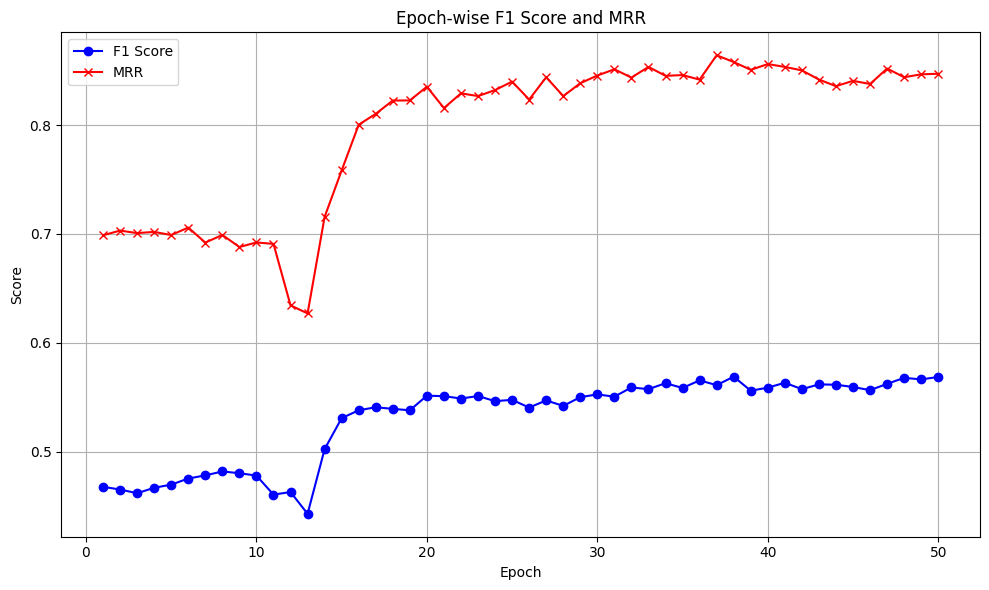

In [22]:
import matplotlib.pyplot as plt

# Simulated epoch-wise data (from your output)
epochs = list(range(1, 51))
f1_scores = [
    0.4676, 0.4651, 0.4617, 0.4667, 0.4696, 0.4752, 0.4781, 0.4817, 0.4801, 0.4779,
    0.4604, 0.4628, 0.4428, 0.5022, 0.5307, 0.5379, 0.5407, 0.5392, 0.5379, 0.5513,
    0.5509, 0.5487, 0.5510, 0.5463, 0.5475, 0.5404, 0.5470, 0.5419, 0.5500, 0.5525,
    0.5504, 0.5589, 0.5573, 0.5628, 0.5584, 0.5654, 0.5610, 0.5688, 0.5559, 0.5587,
    0.5632, 0.5573, 0.5617, 0.5614, 0.5593, 0.5564, 0.5622, 0.5677, 0.5663, 0.5685
]
mrr_scores = [
    0.6987, 0.7030, 0.7007, 0.7018, 0.6989, 0.7058, 0.6920, 0.6990, 0.6879, 0.6921,
    0.6908, 0.6343, 0.6269, 0.7156, 0.7583, 0.8003, 0.8103, 0.8225, 0.8226, 0.8352,
    0.8156, 0.8291, 0.8266, 0.8321, 0.8399, 0.8234, 0.8439, 0.8266, 0.8384, 0.8455,
    0.8512, 0.8436, 0.8534, 0.8452, 0.8459, 0.8417, 0.8641, 0.8579, 0.8507, 0.8560,
    0.8534, 0.8502, 0.8418, 0.8357, 0.8406, 0.8377, 0.8519, 0.8439, 0.8466, 0.8471
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, label='F1 Score', marker='o', color='blue')
plt.plot(epochs, mrr_scores, label='MRR', marker='x', color='red')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Epoch-wise F1 Score and MRR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("epoch_wise.png", dpi=300)
plt.show()


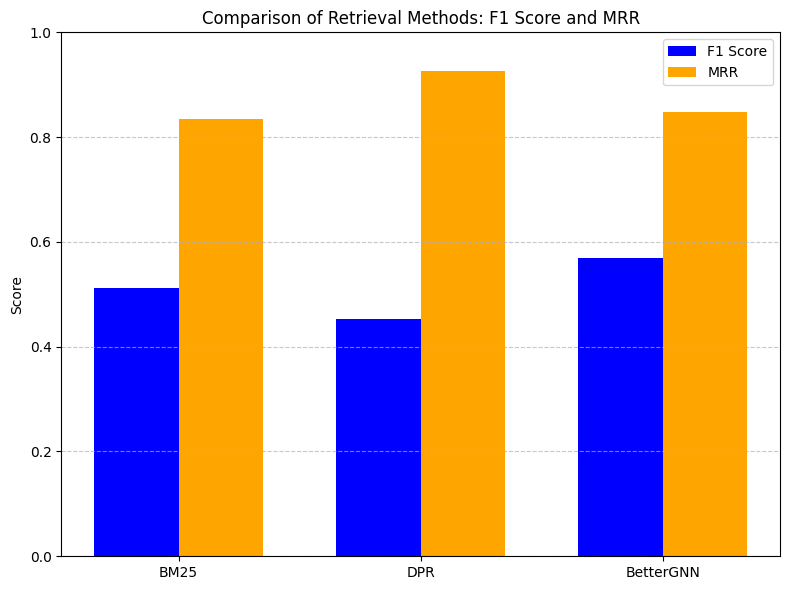

In [24]:
import matplotlib.pyplot as plt

# Labels and values
models = ['BM25', 'DPR', 'BetterGNN']
f1_values = [0.5111, 0.4524, 0.5685]
mrr_values = [0.8350, 0.9267, 0.8471]

x = range(len(models))
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
plt.bar([i - bar_width/2 for i in x], f1_values, width=bar_width, label='F1 Score', color='blue')
plt.bar([i + bar_width/2 for i in x], mrr_values, width=bar_width, label='MRR', color='orange')

plt.xticks(ticks=x, labels=models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Comparison of Retrieval Methods: F1 Score and MRR")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("baseline_vs_gnn.png", dpi=300)
plt.show()


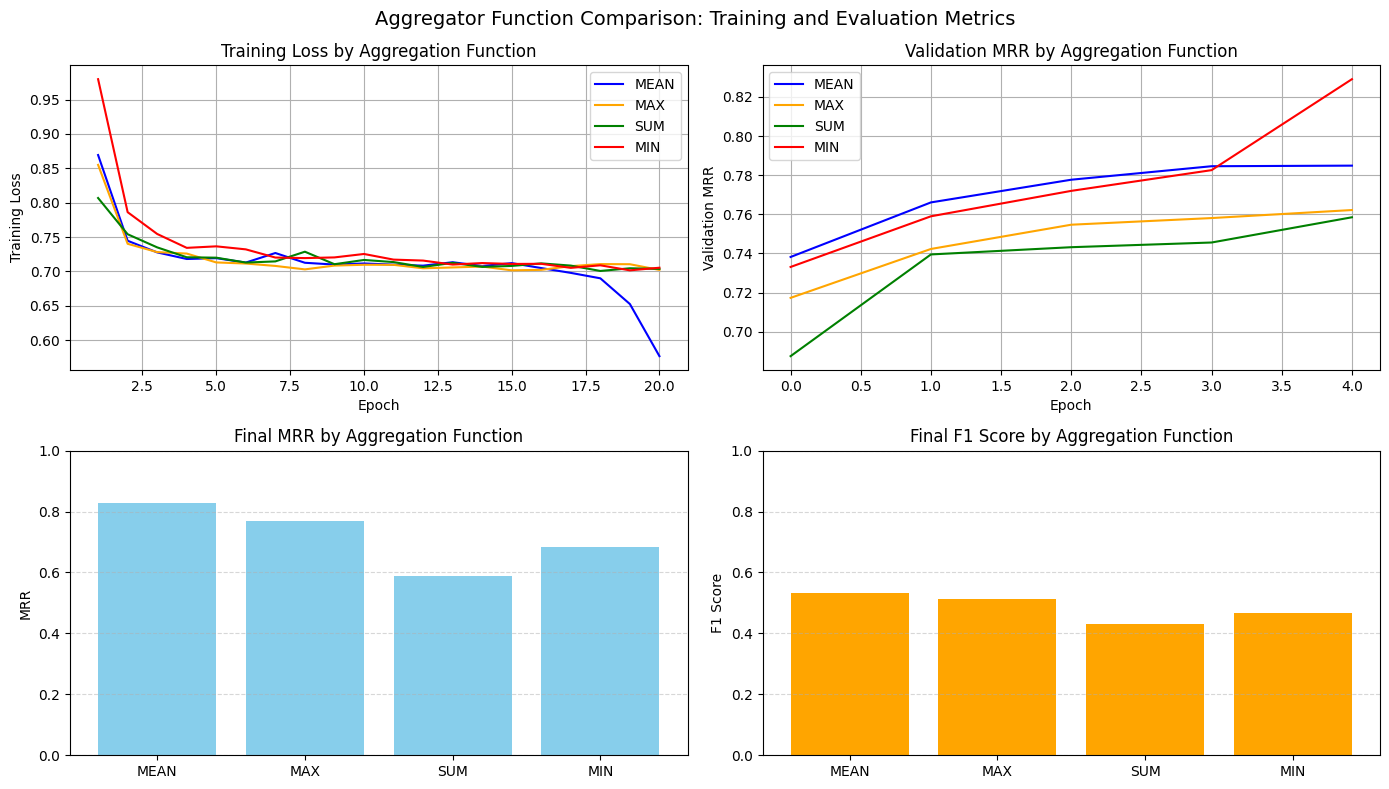

In [33]:
import matplotlib.pyplot as plt

# Aggregator names
aggregators = ['MEAN', 'MAX', 'SUM', 'MIN']

# Final metrics
f1_scores = [0.5323, 0.5116, 0.4312, 0.4659]
mrr_scores = [0.8279, 0.7700, 0.5868, 0.6851]

# Epoch-wise logs for each aggregator
epochs = list(range(1, 21))
loss_mean = [0.8693, 0.7446, 0.7277, 0.7181, 0.7193, 0.7129, 0.7268, 0.7126, 0.7100, 0.7116,
             0.7099, 0.7084, 0.7134, 0.7079, 0.7121, 0.7049, 0.6979, 0.6900, 0.6526, 0.5768]
loss_max = [0.8550, 0.7402, 0.7281, 0.7260, 0.7131, 0.7115, 0.7080, 0.7030, 0.7085, 0.7097,
            0.7096, 0.7046, 0.7058, 0.7071, 0.7016, 0.7023, 0.7077, 0.7107, 0.7105, 0.7022]
loss_sum = [0.8068, 0.7541, 0.7350, 0.7206, 0.7200, 0.7129, 0.7146, 0.7287, 0.7105, 0.7167,
            0.7136, 0.7065, 0.7125, 0.7066, 0.7080, 0.7117, 0.7085, 0.7007, 0.7046, 0.7037]
loss_min = [0.9796, 0.7862, 0.7545, 0.7343, 0.7365, 0.7321, 0.7202, 0.7194, 0.7204, 0.7254,
            0.7172, 0.7158, 0.7100, 0.7122, 0.7109, 0.7111, 0.7052, 0.7089, 0.7016, 0.7054]

mrr_mean = [0.7382, 0.7661, 0.7777, 0.7846, 0.7849]
mrr_max = [0.7173, 0.7423, 0.7547, 0.7581, 0.7622]
mrr_sum = [0.6875, 0.7395, 0.7432, 0.7456, 0.7585]
mrr_min = [0.7331, 0.7590, 0.7720, 0.7826, 0.8291]

# Colors for each aggregator
colors = {
    'MEAN': 'blue',
    'MAX': 'orange',
    'SUM': 'green',
    'MIN': 'red'
}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Training Loss
axs[0, 0].plot(epochs, loss_mean, label="MEAN", color=colors['MEAN'])
axs[0, 0].plot(epochs, loss_max, label="MAX", color=colors['MAX'])
axs[0, 0].plot(epochs, loss_sum, label="SUM", color=colors['SUM'])
axs[0, 0].plot(epochs, loss_min, label="MIN", color=colors['MIN'])
axs[0, 0].set_title("Training Loss by Aggregation Function")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Training Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Validation MRR
axs[0, 1].plot(range(5), mrr_mean, label="MEAN", color=colors['MEAN'])
axs[0, 1].plot(range(5), mrr_max, label="MAX", color=colors['MAX'])
axs[0, 1].plot(range(5), mrr_sum, label="SUM", color=colors['SUM'])
axs[0, 1].plot(range(5), mrr_min, label="MIN", color=colors['MIN'])
axs[0, 1].set_title("Validation MRR by Aggregation Function")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Validation MRR")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Final MRR Bar Plot
axs[1, 0].bar(aggregators, mrr_scores, color='skyblue')
axs[1, 0].set_title("Final MRR by Aggregation Function")
axs[1, 0].set_ylabel("MRR")
axs[1, 0].set_ylim(0, 1)
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Final F1 Bar Plot
axs[1, 1].bar(aggregators, f1_scores, color='orange')
axs[1, 1].set_title("Final F1 Score by Aggregation Function")
axs[1, 1].set_ylabel("F1 Score")
axs[1, 1].set_ylim(0, 1)
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Aggregator Function Comparison: Training and Evaluation Metrics", fontsize=14)
plt.tight_layout()
plt.savefig("aggregator_function_comparison.png", dpi=300)
plt.show()
